In [4]:
from pathlib import Path
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [5]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("..")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output_76GDcgx.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


In [6]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    #X_train.append(np.mean(features, axis=0))
    
    X_train.append(features)
    y_train.append([label]*1000)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344/344 [00:01<00:00, 215.82it/s]


In [7]:

def reduce_y(y):
    y_reduced = list()
    for y_ in y:
        y_reduced.append(np.array([y_[0]]))
    return np.array(y_reduced)


def train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    """
    Split the input data into training, testing, and validation sets
    Args:
        X: input data
        y: labels
        train_size: proportion of data to be used for training
        val_size: proportion of data to be used for validation
        test_size: proportion of data to be used for testing
        random_state: seed for random number generator
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    np.random.seed(random_state)
    n_samples = X.shape[0]
    idx = np.random.permutation(n_samples)
    X, y = X[idx], y[idx]
    train_end = int(train_size * n_samples)
    val_end = int((train_size + val_size) * n_samples)
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, X_val, X_test, reduce_y(y_train), reduce_y(y_val), reduce_y(y_test)

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_train, y_train, train_size=0.8, val_size=.2, test_size=0)



In [21]:
X_train_tiles = X_train.reshape(-1, 2048).

In [30]:
X_train.reshape(-1, 2048).shape

(275000, 2048)

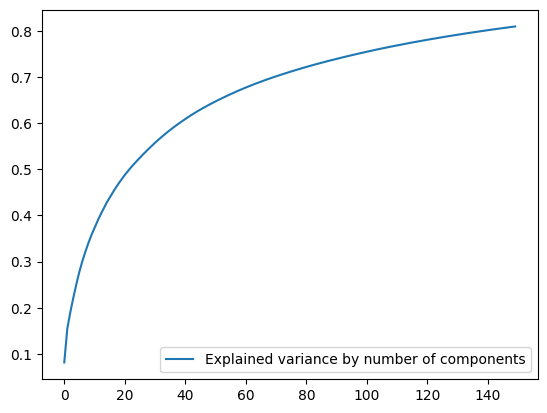

In [23]:
from sklearn.decomposition import PCA
## PCA
pca_tiles = PCA(n_components = 150)
X_train_tiles = pca_tiles.fit_transform(X_train_tiles)

V_exp = np.cumsum(pca_tiles.explained_variance_ratio_)
plt.plot(V_exp, label = 'Explained variance by number of components')
plt.legend()




In [31]:
X_train_tiles.shape

(275000, 150)

In [37]:
X_train = X_train_tiles.reshape(275,1000,150)

In [40]:
y_train.shape

(275, 1)

In [41]:
import misvm
classifier = misvm.MISVM(kernel='linear', C=1.0, max_iters=-1)

In [42]:
X_train.shape

(275, 1000, 150)

In [ ]:
classifier.fit(X_train, y_train)